# Modeling with StatsModels

## 1. Ordinary Least Square
- Column Names
- Log Transformation
- Condition Number
- Standard Scaling

# 2. Dimensionality Reduction
- ANOVA
- F-test and Feature Influence

# 3. Outlier
- Cook's Distance

# 4. Regularization
- Lasso

# 5. Diagnosis of Regression
- Residual Normality Test
- Partial Regression Plot

# 6. Cross Validatoin

# 7. Test
- score

In [23]:
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import warnings
import sys
import datetime
import scipy as sp
import statsmodels.stats.api as sms
import statsmodels.api as sm
from patsy import dmatrix
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import utils.statsmodel_helper as sh
import utils.feature_selection as fs
import utils.preprocessing as pp
import utils.error_calculator as ec

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

df_train_macro = pd.read_csv('../code/data/train_macro7.csv', index_col=0)
df_test_macro = pd.read_csv('../code/data/test_macro7.csv', index_col=0)

sys.setrecursionlimit(1500)

degree = 2
skewness_limit = 1
num_of_cooks = 2
num_of_f_test = 10

# 1. Column Names
## Column Names
Replace -, +, :, ~, * in column name with underscore

In [24]:
new_cols = []
for col in  list(df_train_macro.columns):
    col = col.replace('-', '_').replace('+', '_').replace(':', '_').replace('~', '_').replace('*', '_')
    new_cols.append('_'+col)
df_train_macro.columns = new_cols

new_cols = []
for col in list(df_test_macro.columns):
    col = col.replace('-', '_').replace('+', '_').replace(':', '_').replace('~', '_').replace('*', '_')
    new_cols.append('_'+col)
df_test_macro.columns = new_cols

categorial_ivs = list(set(df_train_macro.columns) - set(df_train_macro._get_numeric_data().columns))
numeric_ivs = df_train_macro._get_numeric_data().columns.drop('_price_doc').tolist()

## Log Transformation
Transform data with skewness greater than 1.

In [25]:
features_to_log = []
for f in df_train_macro._get_numeric_data().columns:
    skewness = sp.stats.skew(df_train_macro[f])
    if skewness > skewness_limit:
        features_to_log.append(f)

for col in df_train_macro._get_numeric_data().columns:
    if col != '_price_doc':
        min_val_train = min(df_train_macro[col])
        min_val_test  = min(df_test_macro[col])
        min_val = min(min_val_train, min_val_test)
        if min_val <= 0:
            df_train_macro[col] += (np.abs(min_val) + 0.1)
            df_test_macro[col]  += (np.abs(min_val) + 0.1)
    else:
        min_val_train = min(df_train_macro[col])
        if min_val_train <= 0:
            df_train_macro[col] += (np.abs(min_val_train) + 0.1)

In [26]:
formula = sh.make_statsmodels_ols_formula(numeric_ivs, categorial_ivs, '_price_doc', log_vs=features_to_log, degree=degree, scale=False)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     141.8
Date:                Tue, 12 Nov 2019   Prob (F-statistic):               0.00
Time:                        12:12:06   Log-Likelihood:                -20037.
No. Observations:               29321   AIC:                         4.031e+04
Df Residuals:                   29201   BIC:                         4.131e+04
Df Model:                         119                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                  0.5347      0.043     12.563      0.000       0.451       0.618
C(_incineration_raion)[T.yes]                             -0.0094      0.023     -0.413      0.680      -0.054       0.035
C(_oil_chemistry_raion)[T.yes]                            -0.1633      0.036     -4.563      0.000      -0.233      -0.093
C(_culture_objects_top_25)[T.yes]                          0.0618      0.020      3.071      0.002       0.022       0.101
C(_radiation_raion)[T.yes]                                -0.0452      0.009     -4.890      0.000      -0.063      -0.027
C(_big_market_raion)[T.yes]                                0.0384      0.017      2.259      0.024       0.005       0.072
C(_water_1line)[T.yes]                                     0.0116      0.012      0.936      0.349      -0.013       0.036
C(_big_road1_1line)[T.yes]                                -0.0267      0.020     -1.314      0.189      -0.066       0.013
C(_railroad_terminal_raion)[T.yes]                         0.0521      0.030      1.731      0.083      -0.007       0.111
C(_product_type)[T.OwnerOccupier]                          0.1571      0.012     13.167      0.000       0.134       0.180
C(_ecology)[T.good]                                        0.0272      0.018      1.533      0.125      -0.008       0.062
C(_ecology)[T.no data]                                    -0.0748      0.030     -2.519      0.012      -0.133      -0.017
C(_ecology)[T.poor]                                        0.0243      0.014      1.764      0.078      -0.003       0.051
C(_ecology)[T.satisfactory]                                0.0649      0.018      3.528      0.000       0.029       0.101
C(_detention_facility_raion)[T.yes]                       -0.0203      0.013     -1.523      0.128      -0.047       0.006
C(_nuclear_reactor_raion)[T.yes]                          -0.0023      0.021     -0.112      0.911      -0.042       0.038
C(_thermal_power_plant_raion)[T.yes]                      -0.0077      0.017     -0.457      0.647      -0.041       0.025
C(_railroad_1line)[T.yes]                                 -0.0790      0.027     -2.943      0.003      -0.132      -0.026
np.log(_usdrub)                                            4.0773      0.477      8.550      0.000       3.143       5.012
np.log(_full_sq)                                          -0.1488      0.066     -2.252      0.024      -0.278      -0.019
np.log(_life_sq)                                           0.0112      0.015      0.751      0.452      -0.018       0.040
_floor                                                     0.0081      0.002      4.743      0.000       0.005       0.011
_max_flo

## Condition Number
Large condition number occurs when the scale of data changes significantly due to the unit difference. Scaling can decrease condition number. Multicollinearity can also cause large condition number. We can handle this by reducing dimensionality with variance inflation factor.

## Standard Scaling
Standalize variables by removing the mean and scaling to unit variance.

In [27]:
formula = sh.make_statsmodels_ols_formula(numeric_ivs, categorial_ivs, '_price_doc', log_vs=features_to_log, degree=degree, scale=True)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     125.9
Date:                Tue, 12 Nov 2019   Prob (F-statistic):               0.00
Time:                        12:12:49   Log-Likelihood:                -20037.
No. Observations:               29321   AIC:                         4.034e+04
Df Residuals:                   29186   BIC:                         4.146e+04
Df Model:                         134                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        15.5624      0.017    902.071      0.000      15.529      15.596
C(_incineration_raion)[T.yes]                                    -0.0075      0.023     -0.325      0.745      -0.053       0.038
C(_oil_chemistry_raion)[T.yes]                                   -0.1604      0.035     -4.523      0.000      -0.230      -0.091
C(_culture_objects_top_25)[T.yes]                                 0.0596      0.020      2.956      0.003       0.020       0.099
C(_radiation_raion)[T.yes]                                       -0.0460      0.009     -4.965      0.000      -0.064      -0.028
C(_big_market_raion)[T.yes]                                       0.0381      0.017      2.228      0.026       0.005       0.072
C(_water_1line)[T.yes]                                            0.0115      0.012      0.927      0.354      -0.013       0.036
C(_big_road1_1line)[T.yes]                                       -0.0266      0.020     -1.323      0.186      -0.066       0.013
C(_railroad_terminal_raion)[T.yes]                                0.0467      0.030      1.557      0.119      -0.012       0.106
C(_product_type)[T.OwnerOccupier]                                 0.1555      0.012     13.034      0.000       0.132       0.179
C(_ecology)[T.good]                                               0.0244      0.018      1.340      0.180      -0.011       0.060
C(_ecology)[T.no data]                                           -0.0761      0.031     -2.465      0.014      -0.137      -0.016
C(_ecology)[T.poor]                                               0.0233      0.014      1.656      0.098      -0.004       0.051
C(_ecology)[T.satisfactory]                                       0.0628      0.019      3.329      0.001       0.026       0.100
C(_detention_facility_raion)[T.yes]                              -0.0210      0.013     -1.569      0.117      -0.047       0.005
C(_nuclear_reactor_raion)[T.yes]                                 -0.0019      0.021     -0.091      0.927      -0.042       0.039
C(_thermal_power_plant_raion)[T.yes]                             -0.0074      0.017     -0.433      0.665      -0.041       0.026
C(_railroad_1line)[T.yes]                                        -0.0782      0.027     -2.908      0.004      -0.131      -0.025
scale(np.log(_usdrub))                                            0.8788      0.117      7.539      0.000       0.650       1.107
scale(np.log(_full_sq))                                          -0.0519      0.023     -2.261      0.024      -0.097      -0.007
scale(np.log(_life_sq))                                           0.0066      0.008      0.82

Scaling did not significantly decrease the condition number.

# 2. Dimensionality Reduction
## ANOVA

In [28]:
anova = sm.stats.anova_lm(result, typ=2)
anova

,sum_sq,df,F,PR(>F)
C(_incineration_raion),0.024395,1.0,0.105736,7.450546e-01
C(_oil_chemistry_raion),4.720150,1.0,20.458361,6.118257e-06
C(_culture_objects_top_25),2.016663,1.0,8.740743,3.114266e-03
C(_radiation_raion),5.686607,1.0,24.647241,6.923097e-07
C(_big_market_raion),1.145419,1.0,4.964545,2.587970e-02
C(_water_1line),0.198231,1.0,0.859186,3.539743e-01
C(_big_road1_1line),0.404081,1.0,1.751393,1.857121e-01
C(_railroad_terminal_raion),0.559275,1.0,2.424046,1.194968e-01
C(_product_type),39.194730,1.0,169.880190,1.008171e-38
C(_ecology),7.825851,4.0,8.479820,7.809437e-07



We can remove features with p-value equal or greater than 0.05 since they have very small influences on the dependent variable

## F-test and Feature Influence

In [29]:
result, sms_vars, formula = fs.by_f_test(df_train_macro, formula, repeat=num_of_f_test)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     235.4
Date:                Tue, 12 Nov 2019   Prob (F-statistic):               0.00
Time:                        12:17:05   Log-Likelihood:                -20098.
No. Observations:               29321   AIC:                         4.034e+04
Df Residuals:                   29249   BIC:                         4.094e+04
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        15.5468      0.014   1129.314      0.000      15.520      15.574
C(_oil_chemistry_raion)[T.yes]                                   -0.1422      0.031     -4.581      0.000      -0.203      -0.081
C(_culture_objects_top_25)[T.yes]                                 0.0570      0.018      3.155      0.002       0.022       0.092
C(_radiation_raion)[T.yes]                                       -0.0478      0.008     -5.689      0.000      -0.064      -0.031
C(_big_market_raion)[T.yes]                                       0.0357      0.015      2.358      0.018       0.006       0.065
C(_product_type)[T.OwnerOccupier]                                 0.1564      0.011     14.859      0.000       0.136       0.177
C(_ecology)[T.good]                                               0.0382      0.016      2.365      0.018       0.007       0.070
C(_ecology)[T.no data]                                           -0.0644      0.024     -2.697      0.007      -0.111      -0.018
C(_ecology)[T.poor]                                               0.0459      0.012      3.689      0.000       0.022       0.070
C(_ecology)[T.satisfactory]                                       0.0851      0.017      5.032      0.000       0.052       0.118
C(_railroad_1line)[T.yes]                                        -0.0822      0.026     -3.147      0.002      -0.133      -0.031
scale(np.log(_usdrub))                                            0.9087      0.114      7.957      0.000       0.685       1.133
scale(np.log(_full_sq))                                          -0.0464      0.023     -2.035      0.042      -0.091      -0.002
scale(_floor)                                                     0.0289      0.003      9.512      0.000       0.023       0.035
scale(_num_room)                                                 -0.0368      0.013     -2.736      0.006      -0.063      -0.010
scale(_state)                                                    -0.1193      0.014     -8.334      0.000      -0.147      -0.091
scale(np.log(_area_m))                                            0.4220      0.150      2.819      0.005       0.129       0.715
scale(np.log(_school_education_centers_top_20_raion))             0.2142      0.031      6.839      0.000       0.153       0.276
scale(np.log(_hospital_beds_raion))                              -0.1066      0.024     -4.482      0.000      -0.153      -0.060
scale(np.log(_university_top_20_raion))                          -0.0189      0.004     -4.389      0.000      -0.027      -0.010
scale(np.log(_build_count_brick))                                 0.0165      0.005      3.31

# 3. Outlier
## Cook's Distance
- Find data with large leverage and residual by calculating Cook's distance.

In [30]:
df_train_macro_with_outliers = df_train_macro.copy(deep=True)
df_train_macro, model, result = pp.remove_outliers(df_train_macro, formula, repeat=2)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     981.1
Date:                Tue, 12 Nov 2019   Prob (F-statistic):               0.00
Time:                        12:17:40   Log-Likelihood:                 184.49
No. Observations:               27256   AIC:                            -225.0
Df Residuals:                   27184   BIC:                             366.4
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        15.6848      0.007   2128.478      0.000      15.670      15.699
C(_oil_chemistry_raion)[T.yes]                                   -0.1050      0.017     -6.343      0.000      -0.138      -0.073
C(_culture_objects_top_25)[T.yes]                                 0.0878      0.010      9.043      0.000       0.069       0.107
C(_radiation_raion)[T.yes]                                       -0.0213      0.004     -4.815      0.000      -0.030      -0.013
C(_big_market_raion)[T.yes]                                       0.0184      0.008      2.334      0.020       0.003       0.034
C(_product_type)[T.OwnerOccupier]                                -0.0028      0.005     -0.507      0.612      -0.014       0.008
C(_ecology)[T.good]                                               0.0355      0.009      4.168      0.000       0.019       0.052
C(_ecology)[T.no data]                                           -0.0623      0.013     -4.954      0.000      -0.087      -0.038
C(_ecology)[T.poor]                                               0.0428      0.007      6.531      0.000       0.030       0.056
C(_ecology)[T.satisfactory]                                       0.0869      0.009      9.734      0.000       0.069       0.104
C(_railroad_1line)[T.yes]                                        -0.1230      0.014     -8.735      0.000      -0.151      -0.095
scale(np.log(_usdrub))                                            0.6157      0.060     10.285      0.000       0.498       0.733
scale(np.log(_full_sq))                                           0.1166      0.026      4.482      0.000       0.066       0.168
scale(_floor)                                                     0.0284      0.002     17.930      0.000       0.025       0.031
scale(_num_room)                                                 -0.0485      0.007     -6.613      0.000      -0.063      -0.034
scale(_state)                                                    -0.0866      0.007    -11.657      0.000      -0.101      -0.072
scale(np.log(_area_m))                                            0.4964      0.079      6.253      0.000       0.341       0.652
scale(np.log(_school_education_centers_top_20_raion))             0.1802      0.017     10.841      0.000       0.148       0.213
scale(np.log(_hospital_beds_raion))                              -0.1177      0.014     -8.690      0.000      -0.144      -0.091
scale(np.log(_university_top_20_raion))                          -0.0100      0.002     -4.444      0.000      -0.014      -0.006
scale(np.log(_build_count_brick))                                 0.0212      0.003      8.12

# 4. Regularization
## Lasso
Find variables with zero coefficient when Lasso regularization is applied.

In [31]:
result_lasso = model.fit_regularized(alpha=0.001, L1_wt=1)

Let's remove features with zero coefficient to reduce dimensionality.

In [32]:
sms_vars = []
for idx, coef in enumerate(result_lasso.params):
    if coef ==0:
        continue
    feature = result_lasso.params.index[idx]
    if feature == 'Intercept':
        continue
    startDelPos = feature.find('[')
    endDelPos = feature.find(']')
    feature = feature.replace(feature[startDelPos:endDelPos+1], '')
    sms_vars.append(feature)

In [33]:
formula = 'np.log(_price_doc) ~ ' + " + ".join(sms_vars)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     3394.
Date:                Tue, 12 Nov 2019   Prob (F-statistic):               0.00
Time:                        12:18:25   Log-Likelihood:                 11693.
No. Observations:               25590   AIC:                        -2.329e+04
Df Residuals:                   25543   BIC:                        -2.291e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                                15.7352      0.004   3797.910      0.000      15.727      15.743
C(_culture_objects_top_25)[T.yes]                         0.1047      0.006     16.525      0.000       0.092       0.117
C(_radiation_raion)[T.yes]                               -0.0155      0.003     -5.698      0.000      -0.021      -0.010
C(_product_type)[T.OwnerOccupier]                        -0.0742      0.004    -20.982      0.000      -0.081      -0.067
C(_ecology)[T.good]                                       0.0241      0.004      5.548      0.000       0.016       0.033
C(_ecology)[T.no data]                                   -0.0648      0.007     -9.816      0.000      -0.078      -0.052
C(_ecology)[T.poor]                                       0.0540      0.004     13.731      0.000       0.046       0.062
C(_ecology)[T.satisfactory]                               0.0865      0.005     17.553      0.000       0.077       0.096
C(_railroad_1line)[T.yes]                                -0.1376      0.007    -18.663      0.000      -0.152      -0.123
scale(np.log(_usdrub))                                    0.0502      0.001     51.432      0.000       0.048       0.052
scale(np.log(_full_sq))                                   0.0651      0.017      3.781      0.000       0.031       0.099
scale(_floor)                                             0.0301      0.001     29.174      0.000       0.028       0.032
scale(_num_room)                                         -0.0058      0.001     -4.234      0.000      -0.008      -0.003
scale(np.log(_school_education_centers_top_20_raion))     0.0100      0.001      8.615      0.000       0.008       0.012
scale(np.log(_hospital_beds_raion))                       0.0076      0.001      6.718      0.000       0.005       0.010
scale(np.log(_build_count_brick))                         0.0294      0.002     19.449      0.000       0.026       0.032
scale(np.log(_build_count_monolith))                     -0.0017      0.002     -1.077      0.281      -0.005       0.001
scale(np.log(_public_transport_station_min_walk))        -0.0172      0.001    -12.469      0.000      -0.020      -0.015
scale(np.log(_railroad_km))                               0.0387      0.001     26.323      0.000       0.036       0.042
scale(np.log(_ice_rink_km))                               0.0155      0.001     10.519      0.000       0.013       0.018
scale(np.log(_big_church_km))                            -0.0124      0.002     -7.553      0.000      -0.016      -0.009
scale(np.log(_cafe_count_500_price_1000))                 0.0102      0.001      7.981      0.000       0.008       0.013
scale(np.log(_leisure_count_500))

# 5. Diagnosis of Regression
## Residual Normality Test

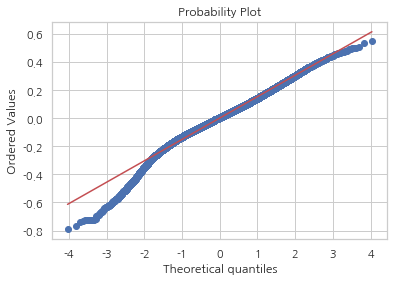

In [34]:
# outlier remove result 
sp.stats.probplot(result.resid, plot=plt)
plt.show()

In [35]:
test = sms.omni_normtest(result.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       : 1534.513
P-value     :  0.000


# Partial Regression Plot
Let's visualize the influence of a single independent variable.

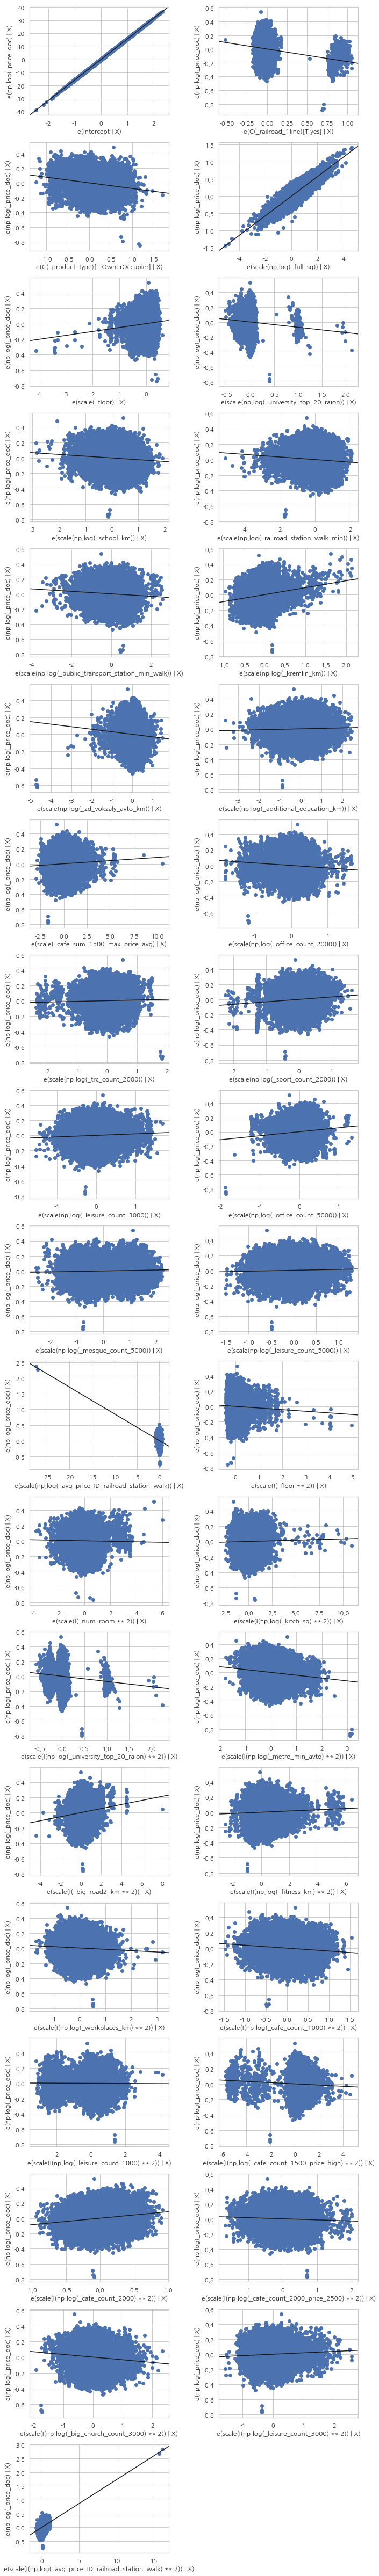

In [15]:
fig = plt.figure(figsize=(10,70))
sm.graphics.plot_partregress_grid(result, fig=fig)
fig.suptitle("")
plt.show()

# 6. Cross Validation

In [16]:
dm = dmatrix(" + ".join(sms_vars) + ' + np.log(_price_doc)', df_train_macro_with_outliers, return_type="dataframe")
X = dm[dm.columns.drop(['np.log(_price_doc)'])]
y = dm['np.log(_price_doc)']
cv = cv = KFold(n_splits=1000, shuffle=True, random_state=0)
r2s = cross_val_score(SMWrapper(sm.OLS), X, y, scoring='r2', cv=cv)
r2s.mean()

0.3764773779617027

(array([ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,
         1.,  0.,  2.,  0.,  0.,  2.,  1.,  0.,  2.,  2.,  3.,  2.,  4.,
         5.,  4.,  7.,  5.,  4.,  5.,  7., 10., 17.,  9.,  9.,  8., 10.,
        10., 17., 12., 15., 11., 19., 16., 18., 21., 18., 28., 29., 15.,
        29., 36., 27., 25., 36., 30., 36., 24., 27., 24., 23., 28., 30.,
        31., 19., 25., 23., 18., 13., 20., 13., 12., 17., 10., 11., 14.,
        13.,  4.,  4.,  7.,  1.,  8.,  3.,  1.,  3.]),
 array([-0.66698181, -0.65180226, -0.63662271, -0.62144315, -0.6062636 ,
        -0.59108405, -0.5759045 , -0.56072494, -0.54554539, -0.53036584,
        -0.51518629, -0.50000673, -0.48482718, -0.46964763, -0.45446807,
        -0.43928852, -0.42410897, -0.40892942, -0.39374986, -0.37857031,
        -0.36339076, -0.34821121, -0.33303165, -0.3178521 , -0.30267255,
        -0.28749299, -0.27231344, -0.25713389, -0.24195434, -0.226774

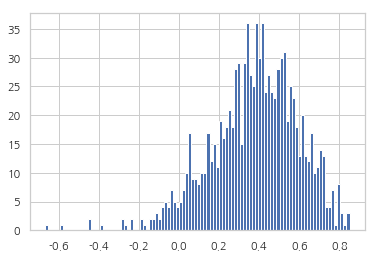

In [17]:
plt.hist(r2s, bins=100)

In [18]:
y_pred = np.exp(result.predict(df_test_macro))
y_pred = y_pred.to_frame('price_doc')
y_pred.to_csv('./data/stats_models_{}.csv'.format(datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')), header=True, index=True)

In [19]:
df_test_macro.tail(1)

,_timestamp,_full_sq,_life_sq,_floor,_material,_num_room,_kitch_sq,_product_type,_area_m,_preschool_education_centers_raion,_school_education_centers_raion,_school_education_centers_top_20_raion,_hospital_beds_raion,_healthcare_centers_raion,_university_top_20_raion,_sport_objects_raion,_culture_objects_top_25,_shopping_centers_raion,_office_raion,_thermal_power_plant_raion,_incineration_raion,_oil_chemistry_raion,_radiation_raion,_railroad_terminal_raion,_big_market_raion,_nuclear_reactor_raion,_detention_facility_raion,_0_17_all,_build_count_brick,_build_count_monolith,_metro_min_avto,_metro_km_avto,_metro_min_walk,_kindergarten_km,_school_km,_park_km,_railroad_station_walk_min,_railroad_station_avto_min,_public_transport_station_min_walk,_water_1line,_ttk_km,_sadovoe_km,_bulvar_ring_km,_kremlin_km,_big_road1_km,_big_road1_1line,_big_road2_km,_railroad_1line,_zd_vokzaly_avto_km,_bus_terminal_avto_km,_oil_chemistry_km,_nuclear_reactor_km,_radiation_km,_power_transmission_line_km,_thermal_power_plant_km,_ts_km,_market_shop_km,_fitness_km,_swim_pool_km,_ice_rink_km,_stadium_km,_basketball_km,_hospice_morgue_km,_detention_facility_km,_public_healthcare_km,_university_km,_workplaces_km,_shopping_centers_km,_office_km,_additional_education_km,_preschool_km,_big_church_km,_church_synagogue_km,_mosque_km,_theater_km,_museum_km,_exhibition_km,_catering_km,_ecology,_office_count_500,_office_sqm_500,_cafe_count_500,_cafe_count_500_price_1000,_cafe_count_500_price_1500,_leisure_count_500,_office_count_1000,_office_sqm_1000,_cafe_count_1000,_cafe_count_1000_na_price,_cafe_count_1000_price_1000,_cafe_count_1000_price_1500,_cafe_count_1000_price_high,_leisure_count_1000,_sport_count_1000,_office_count_1500,_office_sqm_1500,_trc_count_1500,_cafe_count_1500,_cafe_sum_1500_min_price_avg,_cafe_sum_1500_max_price_avg,_cafe_avg_price_1500,_cafe_count_1500_na_price,_cafe_count_1500_price_500,_cafe_count_1500_price_1000,_cafe_count_1500_price_1500,_cafe_count_1500_price_2500,_cafe_count_1500_price_high,_mosque_count_1500,_leisure_count_1500,_sport_count_1500,_green_part_2000,_office_count_2000,_office_sqm_2000,_trc_count_2000,_trc_sqm_2000,_cafe_count_2000,_cafe_sum_2000_max_price_avg,_cafe_avg_price_2000,_cafe_count_2000_na_price,_cafe_count_2000_price_500,_cafe_count_2000_price_1000,_cafe_count_2000_price_1500,_cafe_count_2000_price_2500,_cafe_count_2000_price_high,_mosque_count_2000,_sport_count_2000,_market_count_2000,_green_part_3000,_office_count_3000,_office_sqm_3000,_trc_count_3000,_trc_sqm_3000,_big_church_count_3000,_church_count_3000,_leisure_count_3000,_sport_count_3000,_market_count_3000,_green_part_5000,_office_count_5000,_office_sqm_5000,_trc_count_5000,_trc_sqm_5000,_big_church_count_5000,_church_count_5000,_mosque_count_5000,_leisure_count_5000,_sport_count_5000,_market_count_5000,_avg_price_ID_metro,_avg_price_ID_railroad_station_walk,_avg_price_ID_big_road1,_avg_price_ID_big_road2,_avg_price_ID_railroad_terminal,_avg_price_ID_bus_terminal,_avg_price_sub_area,_oil_urals,_gdp_quart,_gdp_quart_growth,_cpi,_ppi,_balance_trade,_balance_trade_growth,_usdrub,_eurrub,_brent,_net_capital_export,_average_provision_of_build_contract,_average_provision_of_build_contract_moscow,_rts,_micex,_micex_rgbi_tr,_micex_cbi_tr,_deposits_value,_deposits_growth,_deposits_rate,_mortgage_value,_mortgage_growth,_mortgage_rate,_income_per_cap,_fixed_basket,_rent_price_4_room_bus,_rent_price_3room_bus,_rent_price_2room_bus,_rent_price_1room_bus,_rent_price_3room_eco,_rent_price_2room_eco,_rent_price_1room_eco
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
38135,2016-05-30,63.0,43.9,5.1,b,3.1,7.2,Investment,6206098.885,5.1,5.1,0.1,1204.436004,0.1,0.1,10.1,no,11.1,5.1,no,no,no,no,no,no,no,no,14552,0.1,3.1,3.074336,1.272278,14.167336,0.179474,0.598553,3.013805,15.587705,7.176224,1.015379,no,7.784206,10.97325,12.427532,1

## Score

0.39643